In [50]:
import numpy as np

def loss(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

def loss_d(y_true, y_pred):
    return 2 * y_pred - 2 * y_true

def sigm_fun(x):
    return 1 / (1 + np.exp(-x))
def sigm_d(sigm_val):
    return sigm_val * (1 - sigm_val)

def relu(x):
    return 0 if x < 0 else x
def relu_d(relu_val):
    return 0 if relu_val <= 0 else 1

def softmax(outputs):
    exp_outputs = [math.exp(o) for o in outputs]
    total = sum(exp_outputs)
    return [eo / total for eo in exp_outputs]

def cross_entropy_loss(y_true, y_pred):
    y_true = int(y_true - 1)
    return - (y_true* np.log(y_pred + 1e-10) + (1 - y_true) * np.log(1 - y_pred + 1e-10))

def cross_entropy_loss_d(y_true, y_pred):
    y_true = int(y_true - 1)
    return y_pred - y_true



class Neuron:
    def __init__(self, rng, input_dim, activation_f = sigm_fun, activation_f_d = sigm_d):
        self.activation_f = activation_f
        self.activation_f_d = activation_f_d
        weight_list = []
        for i in range(input_dim):
            weight_list.append(rng.uniform(-1, 1))
        self.weights = np.asarray(weight_list)
        self.b = rng.uniform(-1, 1)
        self.b_grad = 0
        self.w_grad = np.zeros(input_dim)
        self.out_grad = 0
    
    def work(self, inputs):
        self.x = np.array(inputs)
        sum = np.sum(inputs * self.weights) + self.b
        self.output = self.activation_f(sum)
        return self.output

    def x_grad(self, i):
        return self.out_grad * self.activation_f_d(self.output) * self.weights[i]

    def generate_param_grad(self):
        self.w_grad = self.out_grad * self.activation_f_d(self.output) * self.x
        self.b_grad = self.out_grad * self.activation_f_d(self.output)
        
    def update_weights(self, errors, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * errors[i] * self.x[i]
            

class NeuralNet:
    def __init__(self, number_of_neurons_in_layer, hidden_layers, input_dim, number_of_outputs = 1, seed=10):
        self.rng = np.random.default_rng(seed)
        self.layers = []
        self.neurons: list[Neuron] = []
        layer_1 = [Neuron(self.rng, input_dim) for _ in range(number_of_neurons_in_layer)]
        self.layers.append(layer_1)
        self.neurons.extend(layer_1)
        for i in range(hidden_layers - 1):
            current_layer = [Neuron(self.rng, number_of_neurons_in_layer) 
                             for _ in range(number_of_neurons_in_layer)]
            self.neurons.extend(current_layer)
            self.layers.append(current_layer)
        output_layer = []
        for i in range(number_of_outputs):
            output_neuron = Neuron(self.rng, number_of_neurons_in_layer, activation_f=lambda x:x, activation_f_d=lambda x:1)
            output_layer.append(output_neuron)
            self.neurons.append(output_neuron)
        self.layers.append(output_layer)
                                     
    def predict_regre(self, inputs):
        outputs = inputs.copy()
        for layer in self.layers:
            outputs = [neuron.work(outputs) for neuron in layer]
        return outputs[0]
    
    def predict_class(self, inputs):
        outputs = inputs.copy()
        for layer in self.layers:
            outputs = [neuron.work(outputs) for neuron in layer]
        probabilitie = sigm_fun(outputs[0])
    
        return probabilitie

    def backprop_single_input(self, input, expected_value):
        y_pred = self.predict_regre(input)
        error = loss(expected_value, y_pred)
        error_d = loss_d(y_pred=y_pred, y_true=expected_value)
        output_neuron = self.layers[-1][0]
        output_neuron.out_grad = error_d
        output_neuron.generate_param_grad()
        next_layer = self.layers[-1]
        for layer in reversed(self.layers[:-1]):
            for i, neuron in enumerate(layer):
                neuron.w_grad = 0
                neuron.out_grad = 0
                neuron.b_grad = 0
                for next_neuron in next_layer:
                    neuron.out_grad += next_neuron.x_grad(i)
                neuron.generate_param_grad()
        return error
    
    def train_regre(self, X, Y, learning_rate=0.05, epochs = 50, print_logs = False):
        n = len(X)
        for k in range(epochs):
            tot_error = 0
            tot_grad = [(0, 0) for neuron in self.neurons]
            for x, y in zip(X, Y):
                tot_error+=self.backprop_single_input(x, y)
                tot_grad = [(grad[0] + neuron.w_grad, grad[1] + neuron.b_grad) 
                            for grad, neuron in zip(tot_grad, self.neurons)]
            tot_error = tot_error/n
            for grad, neuron in zip(tot_grad, self.neurons):
                neuron.weights -= grad[0] / n * learning_rate
                neuron.b -= grad[1] / n * learning_rate
            if print_logs:
                print(f"Epoch: {k}, mean loss: {tot_error}")
    
    def backprop_binary_input(self, input, expected_value):
        y_pred = self.predict_class(input)
        error = cross_entropy_loss(expected_value, y_pred)
        error_d = cross_entropy_loss_d(y_pred=y_pred, y_true=expected_value)
        output_neuron = self.layers[-1][0]
        output_neuron.out_grad = error_d
        output_neuron.generate_param_grad()
        next_layer = self.layers[-1]
        for layer in reversed(self.layers[:-1]):
            for i, neuron in enumerate(layer):
                neuron.w_grad = 0
                neuron.out_grad = 0
                neuron.b_grad = 0
                for next_neuron in next_layer:
                    neuron.out_grad += next_neuron.x_grad(i)
                neuron.generate_param_grad()
        return error
    
                
    def train_class(self, X, Y, learning_rate=0.05, epochs=50, print_logs = False):
        n = len(X)
        for k in range(epochs):
            tot_error = 0
            tot_grad = [(0, 0) for neuron in self.neurons]
            for x, y in zip(X, Y):
                tot_error+=self.backprop_binary_input(x, y)
                tot_grad = [(grad[0] + neuron.w_grad, grad[1] + neuron.b_grad) 
                            for grad, neuron in zip(tot_grad, self.neurons)]
            tot_error = tot_error/n
            for grad, neuron in zip(tot_grad, self.neurons):
                neuron.weights -= grad[0] / n * learning_rate
                neuron.b -= grad[1] / n * learning_rate
            if print_logs:
                print(f"Epoch: {k}, mean loss: {tot_error}")
                

In [51]:
import math

def evaluate_model_regre(model, X, Y):
    Y_pred = [model.predict_regre(x) for x in X]
    MSE = sum([(y_pred - y)**2 for y_pred, y in zip(Y_pred,Y)]) / len(Y)
    return math.sqrt(MSE)


def evaluate_model_class(model, X, Y):
    Y_pred = [model.predict_regre(x)  for x in X]
    MSE = sum([(y_pred - y-1)**2 for y_pred, y in zip(Y_pred,Y)]) / len(Y)
    return math.sqrt(MSE)

In [52]:
net = NeuralNet(hidden_layers=3,number_of_neurons_in_layer=3,input_dim=3)


x = [2,3,6]
y = 10
net.train_regre([x], [y])
net.predict_regre(x)

np.float64(9.999999204241814)

In [53]:
train_data = np.genfromtxt('./projekt1/regression/data.activation.train.100.csv', delimiter=',')
test_data = np.genfromtxt('./projekt1/regression/data.activation.test.100.csv', delimiter=',')
X_train = train_data[1:, 0]
Y_train = train_data[1:, 1]
X_test = test_data[1:, 0]
Y_test = test_data[1:, 1]

net = NeuralNet(hidden_layers=2,number_of_neurons_in_layer=30,input_dim=1)
net.train_regre(X_train, Y_train, learning_rate=0.003, epochs=200, print_logs=True)

print(f"RMSE on train data {evaluate_model_regre(net, X_train, Y_train)}")
print(f"RMSE on test data {evaluate_model_regre(net, X_test, Y_test)}")

Epoch: 0, mean loss: 15639.93784010736
Epoch: 1, mean loss: 14495.484612534612
Epoch: 2, mean loss: 13391.54979638965
Epoch: 3, mean loss: 12320.909148506797
Epoch: 4, mean loss: 11351.06660639774
Epoch: 5, mean loss: 10502.473563488866
Epoch: 6, mean loss: 9760.835286254449
Epoch: 7, mean loss: 9081.752111564683
Epoch: 8, mean loss: 8427.239448132528
Epoch: 9, mean loss: 7805.032440610013
Epoch: 10, mean loss: 7237.030848222936
Epoch: 11, mean loss: 6720.875770205831
Epoch: 12, mean loss: 6245.734704869882
Epoch: 13, mean loss: 5811.6449946979
Epoch: 14, mean loss: 5418.469345234659
Epoch: 15, mean loss: 5042.512672945741
Epoch: 16, mean loss: 4680.15913939188
Epoch: 17, mean loss: 4337.911373736666
Epoch: 18, mean loss: 4018.4995473640265
Epoch: 19, mean loss: 3723.790273061424
Epoch: 20, mean loss: 3454.017864485194
Epoch: 21, mean loss: 3207.561357980638
Epoch: 22, mean loss: 2982.0764282715595
Epoch: 23, mean loss: 2775.776834750826
Epoch: 24, mean loss: 2587.807118585323
Epoch: 2

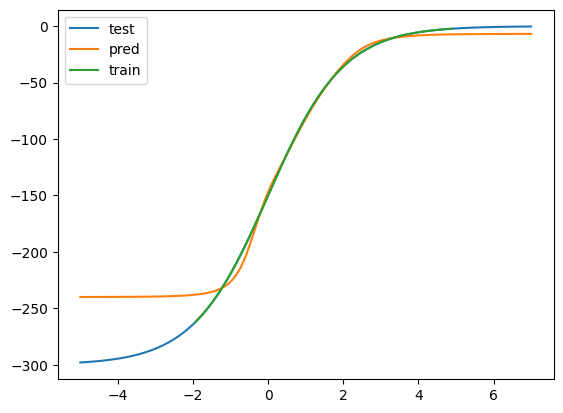

In [54]:
import matplotlib.pyplot as plt
ind = np.argsort(X_train)
plt.plot(X_test, Y_test, label = 'test')
Y_pred = [net.predict_regre(x) for x in X_test]
plt.plot(X_test, Y_pred, label = 'pred')
plt.plot(X_train[ind], Y_train[ind], label = 'train')
plt.legend()

# Classifcation

In [55]:
train_data = np.genfromtxt('./projekt1/classification/data.simple.train.100.csv', delimiter=',')
test_data = np.genfromtxt('./projekt1/classification/data.simple.test.100.csv', delimiter=',')
X_train = train_data[1:, :2]
Y_train = train_data[1:, 2]
X_test = test_data[1:, :2]
Y_test = test_data[1:, 2]

net = NeuralNet(hidden_layers=2,number_of_neurons_in_layer=30,input_dim=2, number_of_outputs = 1)
net.train_class(X_train, Y_train, learning_rate=0.003, epochs=200, print_logs=True)

print(f"RMSE on train data {evaluate_model_class(net, X_train, Y_train)}")
print(f"RMSE on train data {evaluate_model_class(net, X_test, Y_test)}")

Epoch: 0, mean loss: 1.7914715490900974
Epoch: 1, mean loss: 1.781857459673902
Epoch: 2, mean loss: 1.7722632822753517
Epoch: 3, mean loss: 1.7626893545247666
Epoch: 4, mean loss: 1.7531360181226296
Epoch: 5, mean loss: 1.7436036188176802
Epoch: 6, mean loss: 1.7340925063818784
Epoch: 7, mean loss: 1.72460303458211
Epoch: 8, mean loss: 1.7151355611485644
Epoch: 9, mean loss: 1.7056904477396655
Epoch: 10, mean loss: 1.696268059903492
Epoch: 11, mean loss: 1.6868687670355689
Epoch: 12, mean loss: 1.677492942332955
Epoch: 13, mean loss: 1.6681409627445278
Epoch: 14, mean loss: 1.6588132089173786
Epoch: 15, mean loss: 1.6495100651392332
Epoch: 16, mean loss: 1.6402319192768113
Epoch: 17, mean loss: 1.630979162710031
Epoch: 18, mean loss: 1.6217521902620007
Epoch: 19, mean loss: 1.6125514001246952
Epoch: 20, mean loss: 1.6033771937802432
Epoch: 21, mean loss: 1.5942299759177798
Epoch: 22, mean loss: 1.5851101543457475
Epoch: 23, mean loss: 1.5760181398996342
Epoch: 24, mean loss: 1.56695434